# Make figure 7 of the paper
30/08/2023

In [1]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
import json
import os
pipes.plotting.update_rcParams()

# adds in additional chemical evolution models to bagpipes
from code_bits.add_ceh_funcs import *
# adds in VW07 dust to bagpipes
from code_bits.add_VW07_dust import *
# import a bunch of useful functions for interfacing with bagpipes
from code_bits.fitting_MaNGA import *
# adds in additional GP noise kernels to bagpipes
from code_bits.add_GP_SHOTerm import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'
# direction of the skyline file
skyline_dir = 'data'
# bagpipes runID, used to find the right folder that holds the 
# posterior samples file
runID = '10838-1902_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step'
# file name of the posterior samples file
galID = '10838-1902_PSBonly_dereddened_051022'

In [3]:
def get_fit(runID, gal_ID):
    # recover the fit's posterior and run params
    posterior_dir = 'pipes/posterior/'+runID
    json_file = gal_ID+'.json'
    run_params = json.load(open(posterior_dir+'/'+json_file,'r'))
    # change spectrum directory since this demonstration has a
    # slightly different file structure
    run_params['spectrum_dir'] = 'data/stacked_spectrum'
    print('run params:')
    print(run_params)

    pipes.config.R_spec = run_params['Rspec']
    ID_plateifu = run_params['ID_plateifu']
    z = run_params['z']
    
    fit_obj = fitting(skyline_dir, run_params=run_params, full=False)
    
    galaxy = pipes.galaxy(gal_ID, fit_obj.load_manga_spec, photometry_exists=False)

    fit = pipes.fit(galaxy, {}, run=run_params['runID'])
    return run_params, fit, gal_ID, fit_obj

In [4]:
# recover the fit's posterior and run params
run_params, fit, gal_ID, fit_obj = get_fit(runID, galID)
get_advanced_quantities(fit, save=False)
fit._print_results()

run params:
{'data_file_extension': '_PSBonly_dereddened_051022', 'bin_by': 1, 'spectrum_dir': 'data/stacked_spectrum', 'runID_extension': '_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step', 'Rspec': 4340, 'red_phot': False, 'dust_type': 'VW07', 'GP': True, 'GPtype': 'GP_SHOTerm2', 'SHOTerm_period_prior': [0.04, 1.0], 'eta': [1.0, 5.0], 'burstage': [0.0, 4.0], 'SFHcomp': 'psb2', 'ceh': 'twostep', 'zmet_prior': 'log_10', 'n_live': 400, 'ID_plateifu': '10838-1902', 'runID': '10838-1902_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step', 'z': 0.03858788035124397, 'SHOTerm_norm_prior': [0.0001, 0.1]}

Results loaded from pipes/posterior/10838-1902_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/10838-1902_PSBonly_dereddened_051022.h5

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:

In [5]:
# calculate chi squared over dof of the median best fit spectrum
def chi_squared_dof(fit):
    # reconstruct posterior spectrum
    spec_post = np.copy(fit.posterior.samples["spectrum"])
    
    if "calib" in list(fit.posterior.samples):
        spec_post /= fit.posterior.samples["calib"]

    if "noise" in list(fit.posterior.samples):
        spec_post += fit.posterior.samples["noise"]
        
    # take the median spectrum
    spec_post_median = np.median(spec_post, axis=0)
    
    # observed spectrum
    spec_obs = fit.galaxy.spectrum[:,1]
    
    # observational error, scaled by the GP noise white noise scaling
    err_obs = fit.galaxy.spectrum[:,2] * np.median(fit.posterior.samples['noise:scaling'])
    
    chi_squared = np.sum((spec_obs-spec_post_median)**2 / err_obs**2)
    
    # dof = N pixels - N free variables
    dof = len(spec_obs) - fit.fitted_model.ndim
    
    return chi_squared/dof

fit.chi2_nu = chi_squared_dof(fit)
print(fit.chi2_nu)

0.9726255385610951


In [6]:
# return the old and burst component spectrum for each posterior sample
def cal_components(fit, N=500, full=False):
    # N = number of posterior samples considered, max is 500 from bagpipes
    # if full = True, also return the combined model spectrum of the two components
    
    #identify SFH component used
    if "psb2" in fit.fit_instructions.keys():
        SFH_comp = "psb2"
    elif "psb_wild2020" in fit.fit_instructions.keys():
        SFH_comp = "psb_wild2020"
    elif "psb_twin" in fit.fit_instructions.keys():
        SFH_comp = "psb_twin"

    # define some shorthand variables
    samples = fit.posterior.samples
    obs_wavs = fit.galaxy.spectrum[:, 0]
    post_ages = fit.posterior.sfh.ages
    dust_instructions = fit.fit_instructions['dust'].copy()

    # N random draws
    if N < fit.posterior.n_samples:
        samp_ind = np.random.choice(np.arange(fit.posterior.n_samples), size=N, replace=False)
    else:
        samp_ind = np.arange(fit.posterior.n_samples)
        N = fit.posterior.n_samples

    # create empty arrays to hold the spectra
    if full:
        full_model_specs = np.zeros([N, len(obs_wavs)])
    pre_burst_specs = np.zeros([N, len(obs_wavs)])
    post_burst_specs = np.zeros([N, len(obs_wavs)])

    # loop through all samples chosen
    for order,i in enumerate(samp_ind):
        
        # extract sample sfh
        samp_sfh = samples['sfh'][i,:]
        
        # rebuild the sfh model input dictionary
        psb = fit.fit_instructions[SFH_comp].copy()
        for SFH_key in psb.copy().keys():
            if 'prior' in SFH_key:
                psb.pop(SFH_key)
            elif type(psb[SFH_key]) == tuple:
                psb[SFH_key] = samples[f'{SFH_comp}:{SFH_key}'][i]
                
        # rebuild the dust model input dictionary
        dust = dust_instructions.copy()
        for dust_key in dust.keys():
            if 'prior' in dust_key:
                dust.pop(dust_key)
            elif type(dust[dust_key]) == tuple:
                dust[dust_key] = samples[f'dust:{dust_key}'][i]
                
        if full:
            # full combined spectrum
            # create/update new bagpipes model with posterior sample values
            comp = {}
            comp[SFH_comp] = psb
            comp['dust'] = dust
            comp['veldisp'] = samples['veldisp'][i]
            comp['t_bc'] = 0.01
            comp['redshift'] = samples['redshift'][i]

            if order == 0:
                # create model from scratch if first in loop
                full_model = pipes.model_galaxy(comp, spec_wavs=obs_wavs)
            else:
                # using model.update is much faster than create from scratch
                full_model.update(comp)
                
            # save to empty spectra array
            full_model_specs[order,:] = full_model.spectrum[:,1]

        # find the seperation point between old and burst SFHs
        # defined as the minimum SFR between burstage and tform
        in_between_ind = np.where((post_ages>samples[f'{SFH_comp}:burstage'][i]*10**9) &
                                  (post_ages<samples[f'{SFH_comp}:age'][i]*10**9))
        min_sfr_age = post_ages[in_between_ind][np.argmin(samp_sfh[in_between_ind])]
        
        # extract pre-burst sfh
        pre_burst_sfh = np.array([post_ages[post_ages>min_sfr_age],
                                  samp_sfh[post_ages>min_sfr_age]]).T
        
        # extract post-burst sfh
        post_burst_sfh = np.array([post_ages[post_ages<=min_sfr_age],
                                   samp_sfh[post_ages<=min_sfr_age]]).T

        # create new models based on custom sfhs of the components
        if order == 0:
            component_models = []
        for j,sfh_array in enumerate([pre_burst_sfh, post_burst_sfh]):
            
            # use bagpipes custom sfh option to create new models
            custom = {}
            custom['massformed'] = np.log10(np.trapz(x=sfh_array[:,0], y=sfh_array[:,1]))
            custom['history'] = sfh_array
            
            if j==0:
                # simply use old metallicity for the pre-burst component
                custom['metallicity'] = psb['metallicity_old']
            else:
                # need to implement two step metallicity for burst component
                for SFH_key in psb.copy().keys():
                    if 'metallicity' in SFH_key:
                        custom[SFH_key] = psb[SFH_key].copy()

                if 'metallicity_type' in custom.keys():
                    if 'psb_two_step' == custom['metallicity_type']:
                        custom['metallicity_type'] = 'two_step'
                        custom['metallicity_step_age'] = psb['burstage']
                        custom['metallicity_new'] = psb['metallicity_burst']
                        custom.pop('metallicity_burst')

            # build the model component dictionary
            component_comp = {}
            component_comp['custom'] = custom
            component_comp['dust'] = dust
            component_comp['veldisp'] = samples['veldisp'][i]
            component_comp['t_bc'] = 0.01
            component_comp['redshift'] = samples['redshift'][i]

            if order == 0:
                # create model from scratch if first in loop
                component_model = pipes.model_galaxy(component_comp, spec_wavs=obs_wavs)
                component_models.append(component_model)
            else:
                # using model.update is much faster than create from scratch
                component_models[j].update(component_comp)

        # append to the arrays the pre burst model's and post burst model's spectra
        pre_burst_specs[order,:] = component_models[0].spectrum[:,1]
        post_burst_specs[order,:] = component_models[1].spectrum[:,1]
        
    if full:
        return full_model_specs, pre_burst_specs, post_burst_specs
    else:
        return pre_burst_specs, post_burst_specs

In [11]:
def plot_spec_paper(fit, fit_obj, figsize=(15, 12.), N=500):
    # some settings
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)
    
    gal_ID = fit.fname.split('/')[-1][:-1]
    print(gal_ID)

    # make the figure and axes
    fig = plt.figure(figsize=figsize)

    gs1 = matplotlib.gridspec.GridSpec(5, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])
    ax4 = plt.subplot(gs1[4])
    
    # limit spectrum to only the first 3 columns
    if fit.galaxy.spectrum.shape[1] > 3:
        fit.galaxy.spectrum = fit.galaxy.spectrum[:,:3]

    ##### build some useful spectra and masks
    # replace the obs noise of masked wavelength indices with nans
    obs_noise = fit.galaxy.spectrum[:,2].copy()
    obs_noise[obs_noise>9e10] = np.nan
    # get indices that are masked during fitting
    masked_ind = np.where(fit.galaxy.spectrum[:,2]>1)[0]
    # get a spectrum without the wavelength indices that are masked
    non_masked_obs_spec = np.delete(fit.galaxy.spectrum, masked_ind, axis=0)
    # temporarily set obs noise to 0 so they don't show up as shaded regions in plot
    temp_spectrum = fit.galaxy.spectrum.copy()
    temp_spectrum[:, 2] = 0.
    # reconstruct the posterior median spectrum
    if 'noise' in fit.posterior.samples.keys():
        post_median = np.median(fit.posterior.samples["spectrum"]+fit.posterior.samples["noise"], axis=0)
    else:
        post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #======== main panel ========#
    # observed stacked spectrum - black
    y_scale = pipes.plotting.add_spectrum(temp_spectrum, ax1, label='stacked spec', zorder=2, 
                                          color='black')
    # the bagpipes plotting function does not have line width and label 
    # as optional inputs, need to change the line width post-plot
    ax1.lines[0].set_linewidth(1.)
    # and add label
    ax1.lines[0].set_label('stacked spec')
    
    # fitted spectrum - orange and shaded region
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale, zorder=3)
    # need to change the line width and also add label
    ax1.lines[1].set_linewidth(1.)
    ax1.lines[1].set_label('fitted spec')
    
    # adjust y scale of ax1 according to non-masked portion of obs spec
    # masked portions not included so emission and skylines do not drive the limits
    ax1.set_ylim(bottom=0)
    if ax1.get_ylim()[1] > 1.1*max(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(top=1.1*max(non_masked_obs_spec[:,1])*10**-y_scale)
    
    # spectrum without GP noise
    model_spec = np.median(fit.posterior.samples["spectrum"], axis=0)
    ax1.plot(fit.galaxy.spectrum[:,0], model_spec*10**-y_scale, color='royalblue', lw=0.5, 
             label='model spec', zorder=2)
    
    # spectrum of the two components
    pre_burst_specs, post_burst_specs = cal_components(fit, N=N)
    pre_burst_percentiles = np.percentile(pre_burst_specs, (16,50,84), axis=0)
    post_burst_percentiles = np.percentile(post_burst_specs, (16,50,84), axis=0)
    ax1.plot(fit.galaxy.spectrum[:,0], pre_burst_percentiles[1]*10**-y_scale, color='tomato', lw=1, 
             label='older component', zorder=1)
    ax1.plot(fit.galaxy.spectrum[:,0], post_burst_percentiles[1]*10**-y_scale, color='lime', lw=1, 
             label='burst component', zorder=1)
    ax1.fill_between(fit.galaxy.spectrum[:,0], pre_burst_percentiles[0]*10**-y_scale,
                     pre_burst_percentiles[2]*10**-y_scale, color='tomato', alpha=0.2, zorder=-1)
    ax1.fill_between(fit.galaxy.spectrum[:,0], post_burst_percentiles[0]*10**-y_scale,
                     post_burst_percentiles[2]*10**-y_scale, color='lime', alpha=0.2, zorder=-1)
    
    # add text for chi squared over dof
    t = ax1.text(0.02, 0.95, f'$\\chi^2_\\nu = {np.round(fit.chi2_nu,3)}$', va='top', transform=ax1.transAxes,
                 fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=1.0))

    # legend
    leg = ax1.legend(loc='lower right', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    #======== residual panel ========#
    residuals = (fit.galaxy.spectrum[:,1] - post_median)*10**-y_scale
    non_masked_res = np.delete(residuals, masked_ind)
    
    # zero line
    ax3.axhline(0, color="black", ls="--", lw=1)
    
    # residuals plot
    ax3.plot(np.delete(fit.galaxy.spectrum[:,0], masked_ind), non_masked_res, color="sandybrown", lw=1,
             zorder=1)
    
    # plot observational uncertainty along residuals
    ax3.plot(fit.galaxy.spectrum[:,0], obs_noise*10**-y_scale,
            color='cyan', lw=1, zorder=4, label='obs noise')
    # add the scaled noise if it exists
    if 'noise:scaling' in fit.posterior.samples.keys():
        median_noise_scale = np.median(fit.posterior.samples['noise:scaling'])
        ax3.plot(fit.galaxy.spectrum[:,0], obs_noise*median_noise_scale*10**-y_scale,
                color='steelblue', lw=1, zorder=4, ls='--', label='scaled obs noise')

    # axis limits and labels
    ax3.set_ylabel('residual\n($10^{-16}$)')
    max_abs_res = np.max(np.abs(non_masked_res))
    ax3.set_ylim([-1.1*max_abs_res, 1.1*max_abs_res])
    ax3.set_xlim(ax1.get_xlim())

    #======== GPnoise panel ========#
    # zero line
    ax4.axhline(0, color="black", ls="--", lw=1)
    
    if 'noise' in fit.posterior.samples.keys():
        # get the noise spectrum in percentiles
        noise_percentiles = np.percentile(fit.posterior.samples['noise'],(16,50,84),axis=0)*10**-y_scale
        
        # noise plot
        ax4.plot(fit.galaxy.spectrum[:,0], noise_percentiles[1],color="sandybrown", lw=1, zorder=1)
        
        # shaded region
        ax4.fill_between(fit.galaxy.spectrum[:,0], noise_percentiles[0], noise_percentiles[2],
                         color='navajowhite', zorder=-1)
        
        # plot observational uncertainty along GP noise
        ax4.plot(fit.galaxy.spectrum[:,0], obs_noise*10**-y_scale,
                color='cyan', lw=1, zorder=1)
        ylim_ax4 = ax4.get_ylim()
        # add the scaled noise if it exists
        if 'noise:scaling' in fit.posterior.samples.keys():
            median_noise_scale = np.median(fit.posterior.samples['noise:scaling'])
            ax4.plot(fit.galaxy.spectrum[:,0], obs_noise*median_noise_scale*10**-y_scale,
                    color='steelblue', lw=1, zorder=1, ls='--', label='scaled obs noise')

    # axis limits and labels
    ax4.set_xlim(ax1.get_xlim())
    max_abs_ylim_ax4 = np.max(np.abs(ylim_ax4))
    ax4.set_ylim([-max_abs_ylim_ax4,max_abs_ylim_ax4])
    ax4.set_xlabel("Observed wavelength $\\lambda / \\mathrm{\\AA}$")
    ax4.set_ylabel('noise\n($10^{-16}$)')
    
    #======== Misc ========#
    
    # recover masks on spectrum and plot them as gray bands in all panels
    mask_edges = [[masked_ind[0]],[]]
    for i,indi in enumerate(masked_ind[:-1]):
        if masked_ind[i+1] - indi > 1:
            mask_edges[1].append(indi)
            mask_edges[0].append(masked_ind[i+1])
    mask_edges[1].append(masked_ind[-1])
    mask_edges = np.array(mask_edges).T
    
    # plot the gray bands
    ax1_ylims = ax1.get_ylim()
    ax3_ylims = ax3.get_ylim()
    ax4_ylims = ax4.get_ylim()
    for [mask_min, mask_max] in mask_edges:
        ax1.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]],
                         [0,0], [10,10], color='lightgray', zorder=0)
        ax3.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]],
                         [-10,-10], [10,10], color='lightgray', zorder=2)
        ax4.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]],
                         [-10,-10], [10,10], color='lightgray', zorder=2)
    ax1.set_ylim(ax1_ylims)
    ax3.set_ylim(ax3_ylims)
    ax4.set_ylim(ax4_ylims)
    
    # align x tick labels
    for axi in [ax1,ax3,ax4]:
        axi.set_xticks([4000,4500,5000,5500,6000,6500,7000,7500])
    
    return fig, [ax1,ax3,ax4]

10838-1902_PSBonly_dereddened_051022


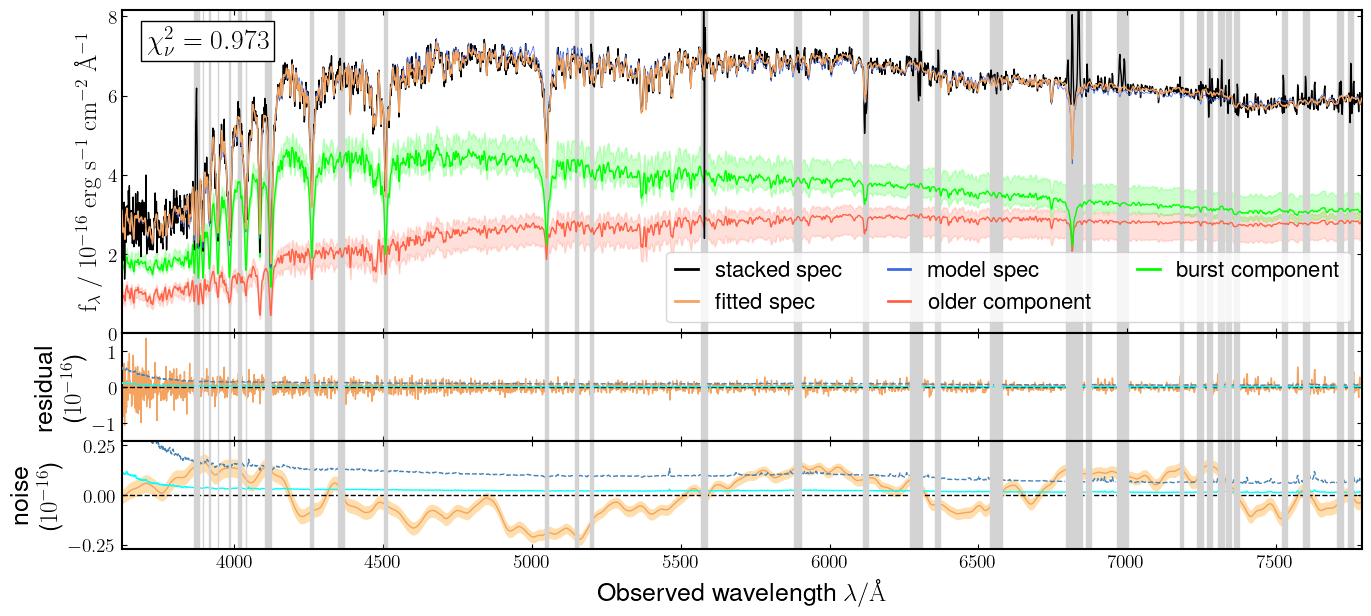

In [13]:
fig, axes = plot_spec_paper(fit, fit_obj, figsize=(16,7), N=500)
plt.show()

In [73]:
fig.savefig(save_dir+'fit_example.pdf', bbox_inches='tight', dpi=200)